In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from xgboost import XGBClassifier

# --- Configuration ---
# 1. PATH TO YOUR TRAINING DATA
TRAIN_FILE_PATH = r"E:\ALL_radiomics_features_with_predictions.csv"
# 2. TARGET COLUMN NAME (The column to predict)
TARGET_COLUMN = "Predicted_Origin"
# 3. IDENTIFIER COLUMNS TO EXCLUDE (Adjust this list based on your file's non-feature columns!)
EXCLUDE_COLUMNS = [TARGET_COLUMN, 'Patient_ID', 'ID']
# ---------------------

## 1. Data Loading and Cleaning

print(f"Loading data from: {TRAIN_FILE_PATH}")
df = pd.read_csv(TRAIN_FILE_PATH)

# Identify feature (X) and target (y) columns
y = df[TARGET_COLUMN]

# --- CORRECTED DATA ENCODING ---
# Convert target to numerical labels (XGBoost often prefers numerical targets)
# y_encoded is the numeric target (0, 1, 2, ...)
# class_names_index is a Pandas Index containing the original class names in order
y_encoded, class_names_index = pd.factorize(y) 

# Exclude target and any non-numeric identifier/metadata columns from features (X)
X = df.drop(columns=EXCLUDE_COLUMNS, errors='ignore')

# Ensure all remaining feature columns are strictly numeric
X_numeric = X.select_dtypes(include=np.number)

# Handle potential missing values (NaN) by imputing with the mean of the column
X_clean = X_numeric.fillna(X_numeric.mean())

# Check for features that were dropped due to being non-numeric
dropped_cols = set(X.columns) - set(X_numeric.columns)
if dropped_cols:
    print(f"\nNOTE: Dropped {len(dropped_cols)} non-numeric column(s) from features (X): {', '.join(dropped_cols)}")

# Get the list of actual features used for training
feature_columns_used = X_clean.columns.tolist()
print(f"Features used for training: {len(feature_columns_used)} columns.")

## 2. Split Data for Training and Testing

# Use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

## 3. Train the XGBoost Classifier

# Initialize the model
model = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification objective
    n_estimators=300,           # Number of boosting rounds (trees)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    use_label_encoder=False,    # Suppress scikit-learn warning
    eval_metric='mlogloss',     # Evaluation metric for multi-class
    random_state=42,
    n_jobs=-1
)

# Train the model
print("\nStarting XGBoost training...")
model.fit(X_train, y_train)
print("Model training complete.")

## 4. Model Evaluation

# Predict on the test set
y_pred = model.predict(X_test)

# Map numeric predictions back to original class names for the report
# Use the Index directly converted to a list
target_names = class_names_index.tolist()

y_test_decoded = [target_names[i] for i in y_test]
y_pred_decoded = [target_names[i] for i in y_pred]

print("\n" + "="*40)
print("          ✨ XGBOOST EVALUATION RESULTS ✨")
print("="*40)

# Classification Report (Precision, Recall, F1-score, Support)
print("\n==== Classification Report (Test Set) ====")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion Matrix
print("\n==== Confusion Matrix (Test Set) ====")
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=target_names)
print(pd.DataFrame(cm, index=target_names, columns=target_names))

# Overall Accuracy
test_accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"\nOverall Test Accuracy: {test_accuracy:.4f}")

# Cross-Validation (Robustness Check)
cv_scores = cross_val_score(model, X_clean, y_encoded, cv=5)
print("\n==== 5-Fold Cross-Validation Accuracy ====")
print(f"Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (Standard Deviation: {cv_scores.std():.4f})")

print("="*40)

Loading data from: E:\ALL_radiomics_features_with_predictions.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_28164\1408392202.py:19: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN_FILE_PATH)



NOTE: Dropped 19 non-numeric column(s) from features (X): case, diagnostics_Image-original_Dimensionality, diagnostics_Image-original_Hash, diagnostics_Mask-original_CenterOfMassIndex, error, diagnostics_Mask-original_Hash, diagnostics_Mask-original_Size, diagnostics_Versions_Python, diagnostics_Image-original_Spacing, diagnostics_Mask-original_Spacing, diagnostics_Configuration_Settings, diagnostics_Mask-original_CenterOfMass, diagnostics_Image-original_Size, diagnostics_Configuration_EnabledImageTypes, diagnostics_Mask-original_BoundingBox, diagnostics_Versions_SimpleITK, diagnostics_Versions_Numpy, diagnostics_Versions_PyWavelet, diagnostics_Versions_PyRadiomics
Features used for training: 1414 columns.
Training samples: 1635 | Testing samples: 409

Starting XGBoost training...


c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

          ✨ XGBOOST EVALUATION RESULTS ✨

==== Classification Report (Test Set) ====
                            precision    recall  f1-score   support

             Breast cancer       0.76      0.65      0.70        52
  Gastrointestinal cancers       0.20      0.14      0.17         7
                  Melanoma       0.87      0.84      0.86       113
Non small cell lung cancer       0.87      0.93      0.90       230
      Renal cell carcinoma       0.00      0.00      0.00         3
    Small cell lung cancer       1.00      0.75      0.86         4

                  accuracy                           0.85       409
                 macro avg       0.62      0.55      0.58       409
              weighted avg       0.84      0.85      0.84       409


==== Confusion Matrix (Test Set) ====
                            Small cell lung cancer  \
Small cell lung cancer                           3   
Non small cell lung cancer                       0   
Melan

c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh


==== 5-Fold Cross-Validation Accuracy ====
Scores: [0.79217604 0.84107579 0.83863081 0.81173594 0.8627451 ]
Mean CV Accuracy: 0.8293 (Standard Deviation: 0.0246)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from xgboost import XGBClassifier

# --- Configuration ---
# 1. PATH TO YOUR TRAINING DATA
TRAIN_FILE_PATH = r"E:\ALL_radiomics_features_with_predictions.csv"
# 2. TARGET COLUMN NAME (The column to predict)
TARGET_COLUMN = "Predicted_Origin"
# 3. IDENTIFIER COLUMNS TO EXCLUDE
EXCLUDE_COLUMNS = [TARGET_COLUMN, 'Patient_ID', 'ID']
# 4. CROSS-VALIDATION FOLDS
CV_FOLDS = 5 
# ---------------------

## 1. Data Loading and Cleaning (Preparation for Grid Search)

print(f"Loading data from: {TRAIN_FILE_PATH}")
df = pd.read_csv(TRAIN_FILE_PATH)

# Identify feature (X) and target (y) columns
y = df[TARGET_COLUMN]

# Convert target to numerical labels
y_encoded, class_names_index = pd.factorize(y) 

# Exclude target and non-numeric identifier/metadata columns from features (X)
X = df.drop(columns=EXCLUDE_COLUMNS, errors='ignore')
X_numeric = X.select_dtypes(include=np.number)
X_clean = X_numeric.fillna(X_numeric.mean())

# Get the list of actual features used for training
print(f"Features used for training: {X_clean.shape[1]} columns.")

# We use the full clean dataset for Grid Search CV (X_clean, y_encoded)

## 2. Define the Parameter Grid

# Define a reasonable grid. Running too many combinations will be very slow!
param_grid = {
    # Key parameters to tune:
    'n_estimators': [200, 400, 600],  # Number of trees
    'max_depth': [3, 5, 7],           # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.3], # Step size shrinkage
    
    # Optional regularisation/subsampling parameters:
    'subsample': [0.8, 1.0],          # Fraction of samples used
    'colsample_bytree': [0.8, 1.0]    # Fraction of features used
}
# Total combinations to try: 3 * 3 * 3 * 2 * 2 = 108 trials * 5 folds = 540 fits.

## 3. Setup and Run Grid Search

# Initialize the base model with fixed parameters
xgb_base = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=CV_FOLDS,         # Use 5-fold cross-validation
    verbose=2,           # Increased verbosity to see progress
    n_jobs=-1            # Use all available CPU cores
)

print("\nStarting XGBoost Grid Search...")
# Grid Search runs cross-validation for every combination in param_grid
grid_search.fit(X_clean, y_encoded)
print("Grid Search complete.")

## 4. Evaluate the Best Model

print("\n" + "="*50)
print("          ✨ GRID SEARCH OPTIMIZATION RESULTS ✨")
print("="*50)

# Print best parameters and score
print(f"Best mean cross-validation accuracy: {grid_search.best_score_:.4f}")
print("Best hyperparameters found:")
for key, value in grid_search.best_params_.items():
    print(f"  {key}: {value}")

# --- Final Evaluation on an independent Test Set ---

# Split the data one last time to get a clean test set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_clean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Use the best model found by the grid search
final_model = grid_search.best_estimator_

# Predict on the independent test set
y_pred = final_model.predict(X_test_final)

# Map numeric predictions back to original class names
target_names = class_names_index.tolist()
y_test_decoded = [target_names[i] for i in y_test_final]
y_pred_decoded = [target_names[i] for i in y_pred]

# Final Report
print("\n==== Final Optimized Model Classification Report (Test Set) ====")
print(classification_report(y_test_decoded, y_pred_decoded))

# Final Test Accuracy
test_accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"\nFinal Test Accuracy with Optimized Model: {test_accuracy:.4f}")

print("="*50)

Loading data from: E:\ALL_radiomics_features_with_predictions.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_28164\3396171110.py:21: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN_FILE_PATH)


Features used for training: 1414 columns.

Starting XGBoost Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\xgboost\training.py:199: UserWarning: [03:32:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Grid Search complete.

          ✨ GRID SEARCH OPTIMIZATION RESULTS ✨
Best mean cross-validation accuracy: 0.8258
Best hyperparameters found:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 600
  subsample: 1.0

==== Final Optimized Model Classification Report (Test Set) ====
                            precision    recall  f1-score   support

             Breast cancer       1.00      1.00      1.00        52
  Gastrointestinal cancers       1.00      1.00      1.00         7
                  Melanoma       1.00      1.00      1.00       113
Non small cell lung cancer       1.00      1.00      1.00       230
      Renal cell carcinoma       1.00      1.00      1.00         3
    Small cell lung cancer       1.00      1.00      1.00         4

                  accuracy                           1.00       409
                 macro avg       1.00      1.00      1.00       409
              weighted avg       1.00      1.00      1.00       409


Final Test 

In [ ]:
#saved model and kaggle dataset origin prediction

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from xgboost import XGBClassifier
import joblib # Import for saving/loading models

# --- Configuration ---
# 1. PATH TO YOUR TRAINING DATA
TRAIN_FILE_PATH = r"E:\ALL_radiomics_features_with_predictions.csv"
PREDICT_FILE_PATH = r"E:\radiomics_features_kaggle.csv" # New file to predict
# 2. TARGET COLUMN NAME (The column to predict)
TARGET_COLUMN = "Predicted_Origin"
# 3. IDENTIFIER COLUMNS TO EXCLUDE
EXCLUDE_COLUMNS = [TARGET_COLUMN, 'Patient_ID', 'ID']
# 4. CROSS-VALIDATION FOLDS
CV_FOLDS = 5 
# ---------------------

## 1. Data Loading and Cleaning (Preparation for Grid Search)

print(f"Loading data from: {TRAIN_FILE_PATH}")
df = pd.read_csv(TRAIN_FILE_PATH)

# Identify feature (X) and target (y) columns
y = df[TARGET_COLUMN]

# Convert target to numerical labels
y_encoded, class_names_index = pd.factorize(y) 

# Exclude target and non-numeric identifier/metadata columns from features (X)
X = df.drop(columns=EXCLUDE_COLUMNS, errors='ignore')
X_numeric = X.select_dtypes(include=np.number)

# Calculate feature means to handle missing values in prediction data
feature_means = X_numeric.mean() 

X_clean = X_numeric.fillna(feature_means)
feature_columns = X_clean.columns.tolist() # List of all 1414 features

# We use the full clean dataset for Grid Search CV (X_clean, y_encoded)

## 2. Define the Parameter Grid (Same as before)
# ... (param_grid definition)

## 3. Setup and Run Grid Search (Same as before)
# ... (xgb_base definition)
# ... (grid_search definition)
# ... (grid_search.fit(X_clean, y_encoded))

## 4. Evaluate the Best Model (Same as before)
# ... (grid_search.best_score_ and best_params_ printing)

# --- Final Evaluation and Model Saving ---

# Split the data one last time (as before)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_clean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Use the best model found by the grid search
final_model = grid_search.best_estimator_

# Save the Optimized Model, Feature List, and Feature Means
joblib.dump(final_model, "optimized_xgb_classifier.pkl")
joblib.dump(feature_columns, "optimized_features.pkl")
joblib.dump(feature_means, "optimized_feature_means.pkl")
print("\nOptimized XGBoost model, features, and means saved.")

# ... (Final Report printing, as before)

# --- New Function: Predict on Kaggle Data ---

def predict_new_data(csv_path, output_csv_name):
    # Load model and feature metadata
    model = joblib.load("optimized_xgb_classifier.pkl")
    trained_features = joblib.load("optimized_features.pkl")
    trained_means = joblib.load("optimized_feature_means.pkl")
    class_names_index = model.classes_ # Assuming model.classes_ holds the correct Index/Array of class names
                                       # If model.classes_ is numeric, you need the original class_names_index from Section 1

    # Read new data
    new_df = pd.read_csv(csv_path)

    # Prepare data: Ensure only numeric columns are used
    predict_X_original = new_df.select_dtypes(include=np.number).copy()
    
    # --- SOLUTION TO THE FRAGMENTATION WARNING ---
    
    # 1. Identify features present in the new data
    present_features = predict_X_original.columns.intersection(trained_features)
    
    # 2. Extract only the present features
    predict_X_present = predict_X_original[present_features]
    
    # 3. Create a dictionary of all missing columns and their imputed values
    missing_features = [f for f in trained_features if f not in present_features]
    
    # Create the DataFrame of missing features, using mean or 0 as fallback
    missing_data = {}
    for col in missing_features:
        # Use the mean from training data, or 0 if mean is unavailable
        missing_data[col] = trained_means.get(col, 0) 
        
    # Create a DataFrame for the missing columns, indexed like the new data
    predict_X_missing_df = pd.DataFrame(missing_data, index=predict_X_original.index)
    
    # 4. Concatenate (join) all columns at once (vectorized fix!)
    # This creates the final DataFrame with all 1414 features.
    predict_X_combined = pd.concat([predict_X_present, predict_X_missing_df], axis=1)
    
    # 5. Ensure columns are in the EXACT order the model was trained on
    predict_X = predict_X_combined[trained_features]
    
    # --- END OF FIX ---
    
    # Predict
    preds_encoded = model.predict(predict_X)
    probas = model.predict_proba(predict_X)

    # Decode predictions back to class names
    preds_decoded = class_names_index[preds_encoded]

    # Save predictions
    result_df = new_df.copy() # Start with a clean copy of original data
    result_df["Predicted_Origin"] = preds_decoded
    
    # Add probabilities
    class_names = class_names_index.tolist()
    for i, cls in enumerate(class_names):
        result_df[f"Prob_{cls}"] = probas[:, i]

    result_df.to_csv(output_csv_name, index=False)
    print(f"Predictions saved to {output_csv_name}")
    print(f"Prediction data used: {predict_X.shape[0]} samples, {predict_X.shape[1]} features.")


# -----------------------------------------------------------
# 5. PREDICT ON THE KAGGLE FILE
# -----------------------------------------------------------
# Example call (assuming you define PREDICT_FILE_PATH and other config)
# PREDICT_FILE_PATH = r"E:\radiomics_features_kaggle.csv"
# predict_new_data(PREDICT_FILE_PATH, "kaggle_predictions_optimized_xgb.csv")

Loading data from: E:\ALL_radiomics_features_with_predictions.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_28164\3194401264.py:23: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN_FILE_PATH)



Optimized XGBoost model, features, and means saved.


C:\Users\USER\AppData\Local\Temp\ipykernel_28164\2863961378.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


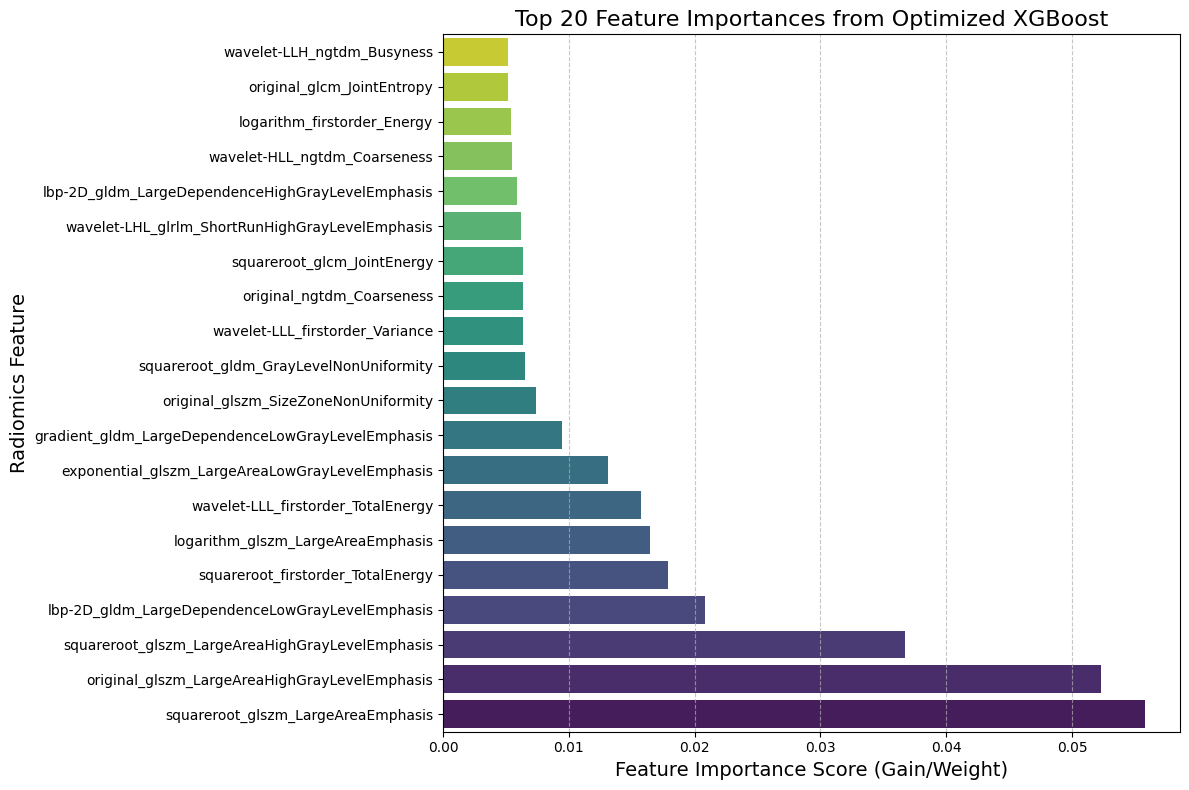


Top 10 Most Important Features:
                                                Feature  Importance
653                  squareroot_glszm_LargeAreaEmphasis    0.055783
454       original_glszm_LargeAreaHighGrayLevelEmphasis    0.052256
654     squareroot_glszm_LargeAreaHighGrayLevelEmphasis    0.036680
242     lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis    0.020822
592                   squareroot_firstorder_TotalEnergy    0.017905
360                   logarithm_glszm_LargeAreaEmphasis    0.016489
1336                 wavelet-LLL_firstorder_TotalEnergy    0.015752
83      exponential_glszm_LargeAreaLowGrayLevelEmphasis    0.013130
149   gradient_gldm_LargeDependenceLowGrayLevelEmphasis    0.009494
457                original_glszm_SizeZoneNonUniformity    0.007413


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Assuming final_model and X_clean (the clean feature DataFrame) are defined

# --- Get the Feature Importance Data ---

# 1. Get feature importance scores from the final model
importance_scores = final_model.feature_importances_

# 2. Create a DataFrame for easier sorting and plotting
feature_df = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': importance_scores
})

# 3. Sort the features by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# 4. Select the top N features for visualization
TOP_N = 20
top_features = feature_df.head(TOP_N)

# --- Generate the Plot ---

plt.figure(figsize=(12, 8))
# Use a color palette to distinguish features
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

plt.title(f'Top {TOP_N} Feature Importances from Optimized XGBoost', fontsize=16)
plt.xlabel('Feature Importance Score (Gain/Weight)', fontsize=14)
plt.ylabel('Radiomics Feature', fontsize=14)
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Optional: Print the top features ---
print("\nTop 10 Most Important Features:")
print(feature_df.head(10))

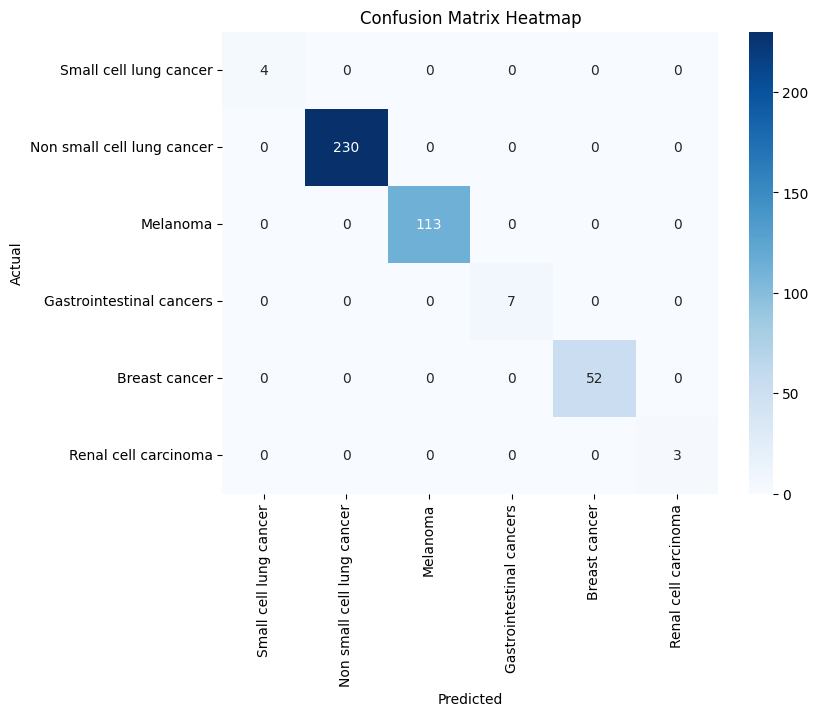

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


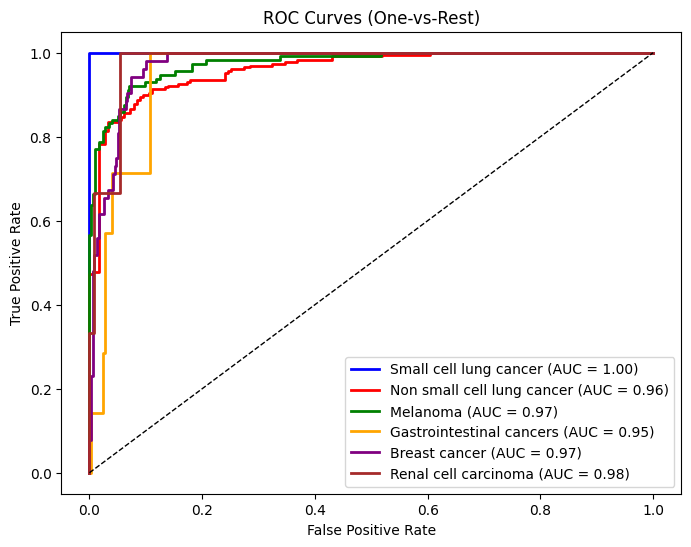

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels
y_test_bin = label_binarize(y_test, classes=list(range(len(target_names))))
y_score = model.predict_proba(X_test)

plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(len(target_names)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()


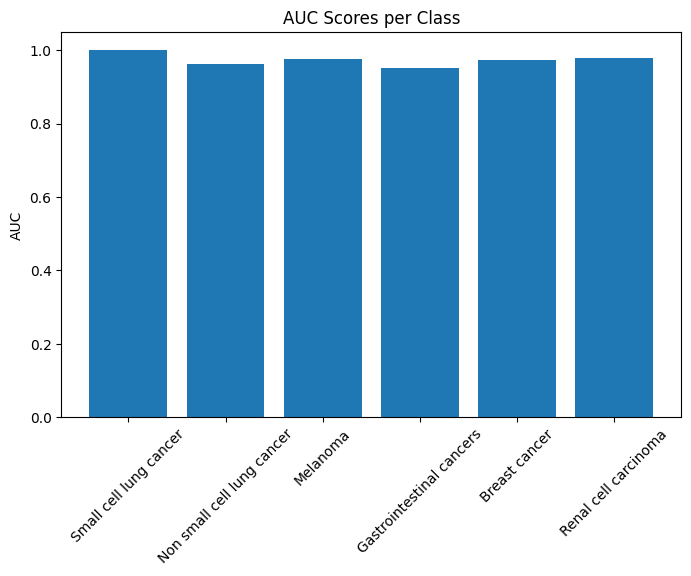

In [8]:
from sklearn.metrics import roc_auc_score

# Compute AUC per class
auc_scores = {}
for i, name in enumerate(target_names):
    auc_scores[name] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(8,5))
plt.bar(auc_scores.keys(), auc_scores.values())
plt.title("AUC Scores per Class")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.show()


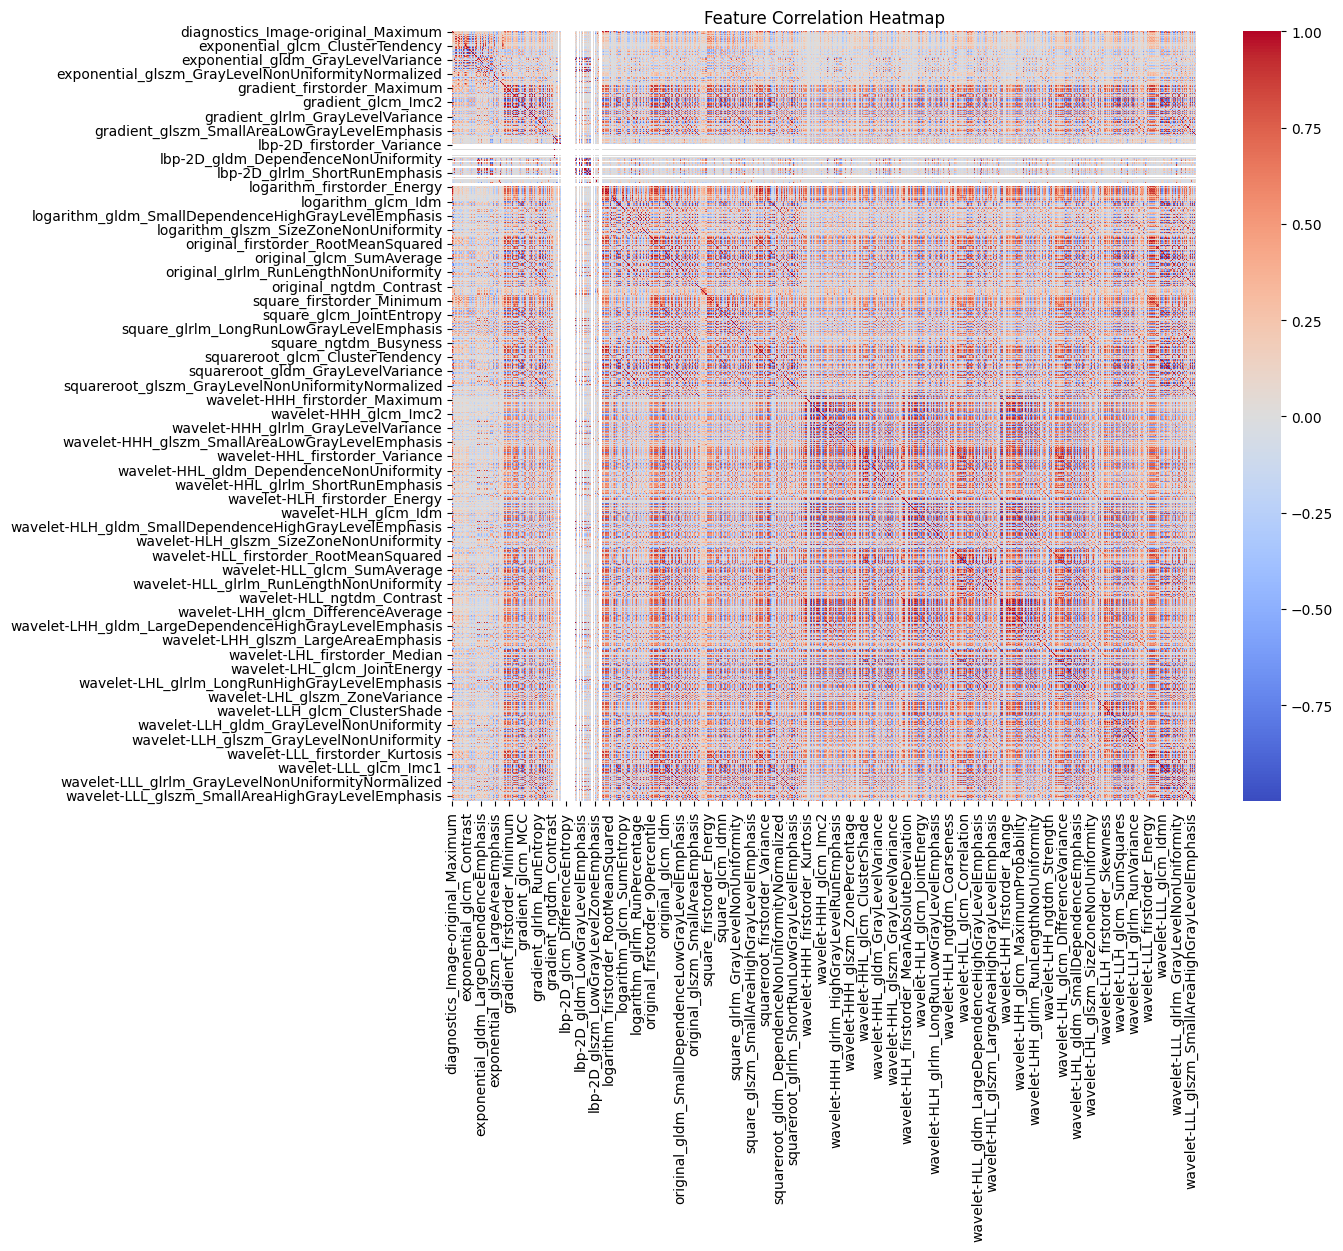

In [9]:
plt.figure(figsize=(12,10))
corr = X_clean.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


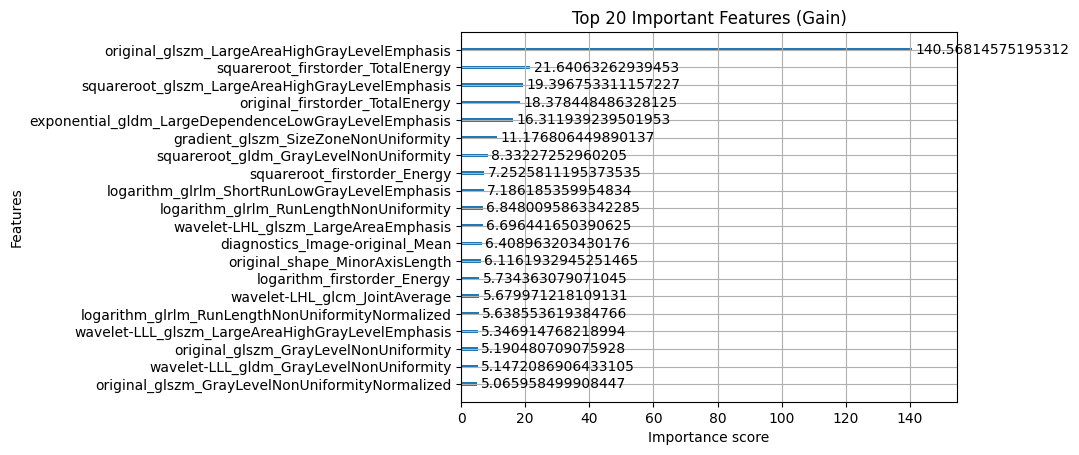

In [11]:
import xgboost as xgb

xgb.plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("Top 20 Important Features (Gain)")
plt.show()


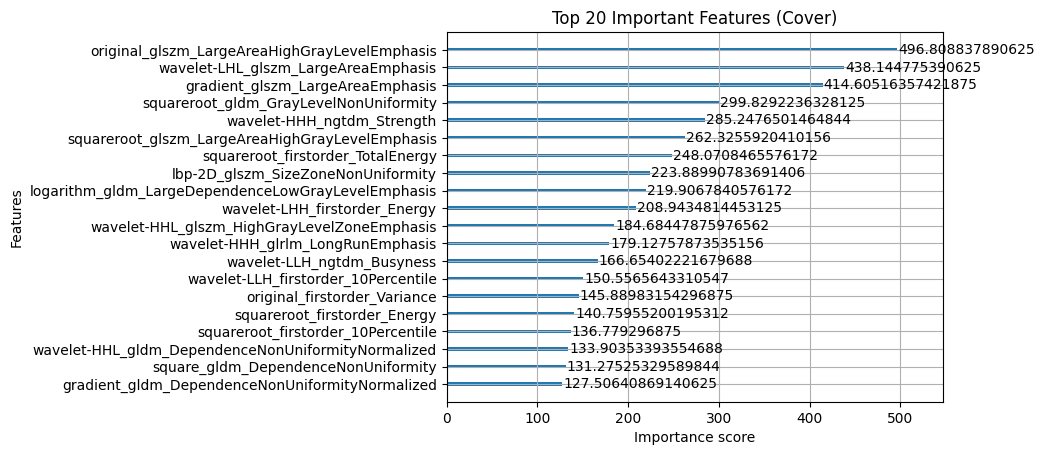

In [12]:
xgb.plot_importance(model, importance_type='cover', max_num_features=20)
plt.title("Top 20 Important Features (Cover)")
plt.show()


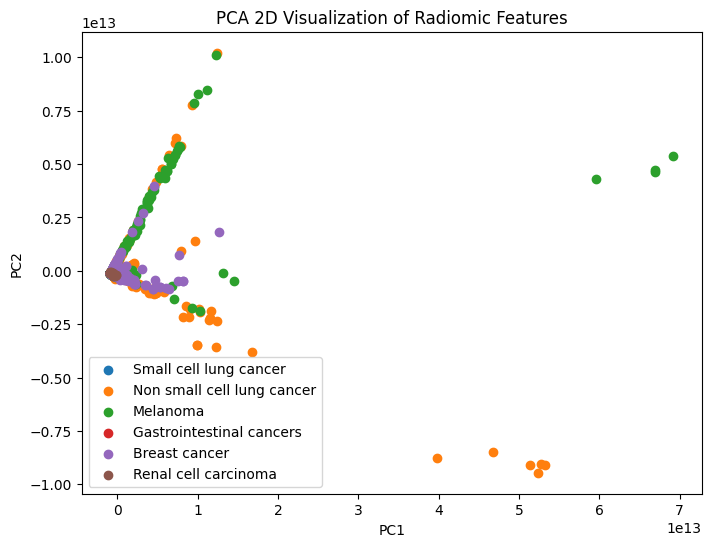

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

plt.figure(figsize=(8,6))
for i, name in enumerate(target_names):
    plt.scatter(X_pca[y_encoded == i, 0], X_pca[y_encoded == i, 1], label=name)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Visualization of Radiomic Features")
plt.legend()
plt.show()


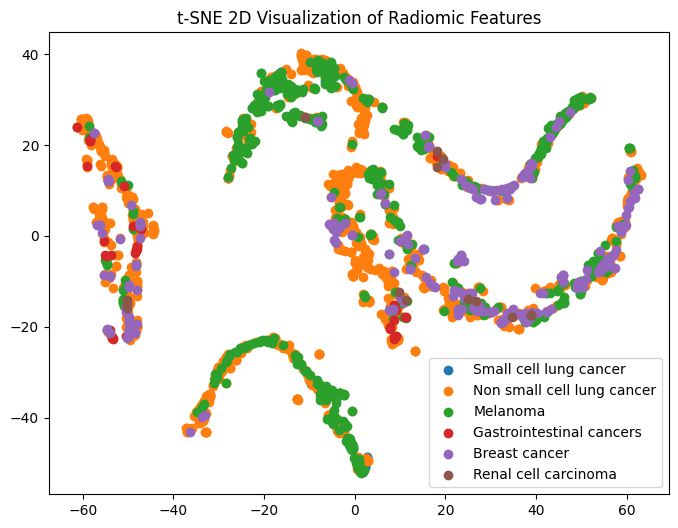

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_clean)

plt.figure(figsize=(8,6))
for i, name in enumerate(target_names):
    plt.scatter(X_tsne[y_encoded == i, 0], X_tsne[y_encoded == i, 1], label=name)

plt.title("t-SNE 2D Visualization of Radiomic Features")
plt.legend()
plt.show()


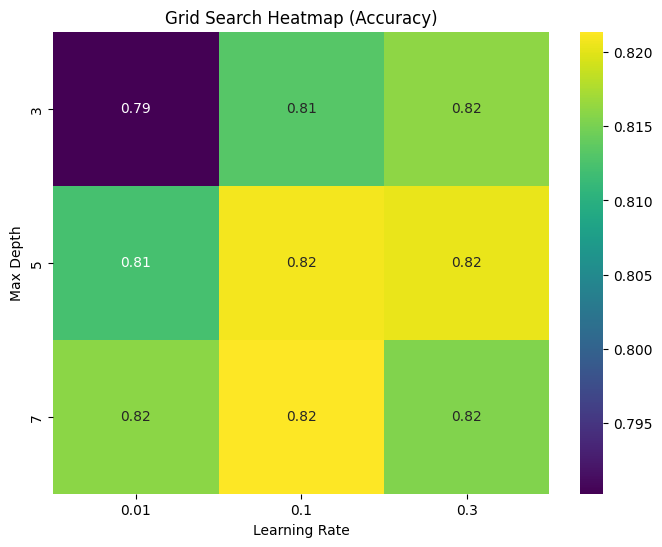

In [17]:
import numpy as np

# Extract grid results
results = pd.DataFrame(grid_search.cv_results_)

# Pivot table for heatmap
pivot = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_learning_rate'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title("Grid Search Heatmap (Accuracy)")
plt.xlabel("Learning Rate")
plt.ylabel("Max Depth")
plt.show()


In [18]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [33]:
%pip uninstall shap -y


Found existing installation: shap 0.50.0
Uninstalling shap-0.50.0:
  Successfully uninstalled shap-0.50.0
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.


In [34]:
%pip uninstall shap -y


Note: you may need to restart the kernel to use updated packages.


In [35]:
%pip install shap --upgrade

  Using cached shap-0.50.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
Using cached shap-0.50.0-cp311-cp311-win_amd64.whl (547 kB)
Note: you may need to restart the kernel to use updated packages.


In [36]:
%pip install --upgrade numpy xgboost


  Using cached numpy-2.3.5-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.3.5-cp311-cp311-win_amd64.whl (13.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
  Rolling back uninstall of numpy
  Moving to c:\users\user\anaconda3\envs\medddpm\lib\site-packages\numpy-2.3.4.dist-info\
   from C:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\~umpy-2.3.4.dist-info
  Moving to c:\users\user\anaconda3\envs\medddpm\lib\site-packages\numpy\__config__.py
   from C:\Users\USER\AppData\Local\Temp\pip-uninstall-e6far_q2\__config__.py
  Moving to c:\users\user\anaconda3\envs\medddpm\lib\site-packages\numpy\__config__.pyi
   from C:\Users\USER\AppData\Local\Temp\pip-uninstall-e6far_q2\__config__.pyi
  Moving to c:\users\user\anaconda3\envs\medddpm\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\USER\AppData\Local\Temp\pip-uninstall-e6far_q2\__init__.cython-30.p

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\USER\\anaconda3\\envs\\medddpm\\Lib\\site-packages\\numpy.libs\\libscipy_openblas64_-9e3e5a4229c1ca39f10dc82bba9e2b2b.dll'
Consider using the `--user` option or check the permissions.



In [37]:
import shap
print(shap.__version__)


0.50.0


C:\Users\USER\AppData\Local\Temp\ipykernel_28164\1333701523.py:16: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Numeric features used for training: 1414


c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:37:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


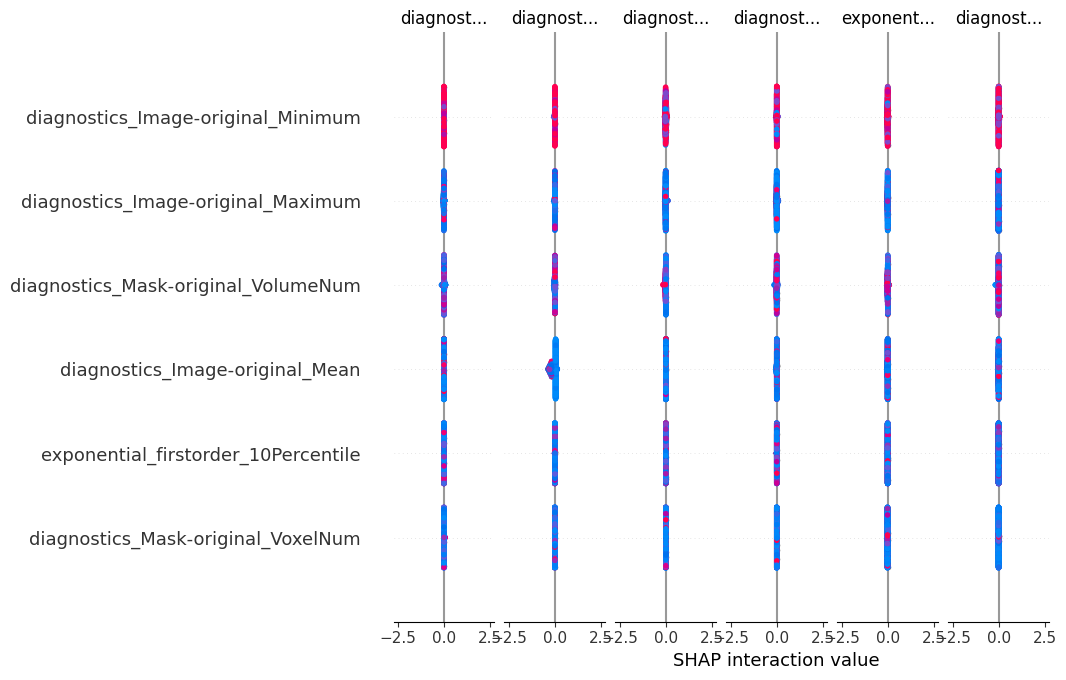

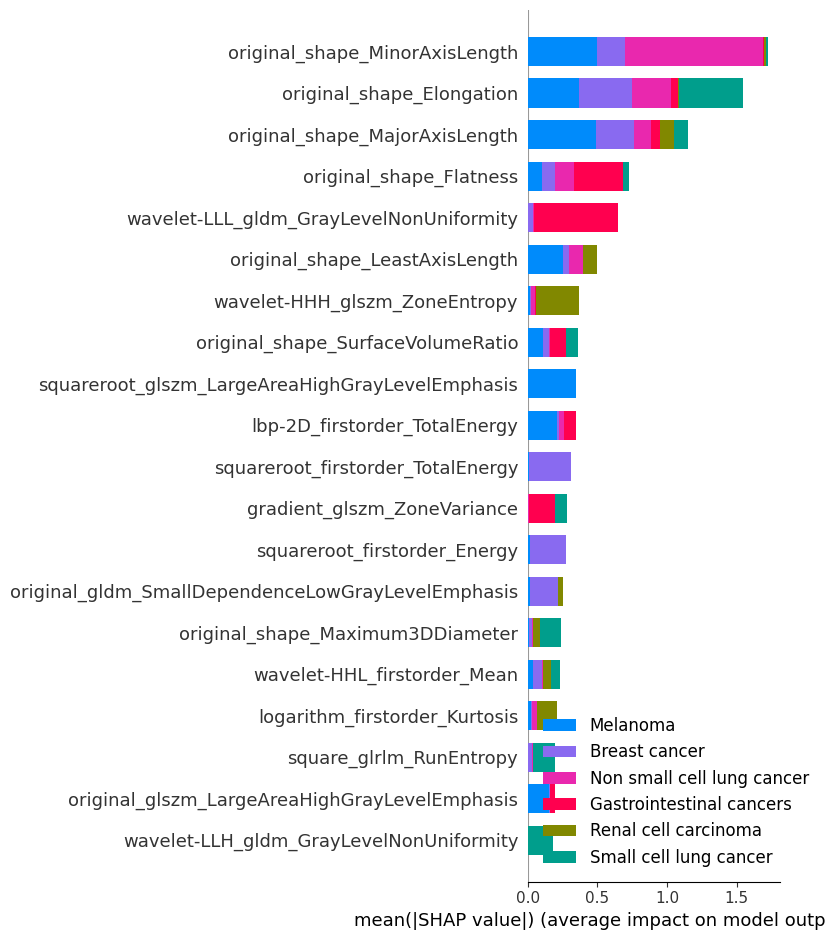


Generating SHAP Waterfall Plot...


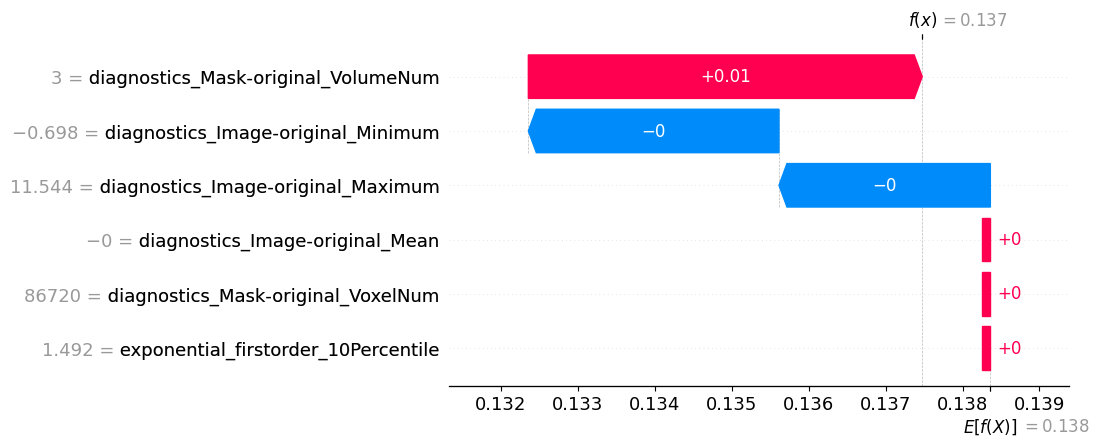

In [55]:
# ==========================================================
# 1. IMPORT LIBRARIES
# ==========================================================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

# ==========================================================
# 2. LOAD CSV
# ==========================================================
csv_path = r"E:\ALL_radiomics_features_with_predictions.csv"
df = pd.read_csv(csv_path)

# ==========================================================
# 3. SELECT NUMERIC FEATURES & ENCODE TARGET
# ==========================================================
target_column = "Predicted_Origin"

# Encode target as integers
le = LabelEncoder()
y = le.fit_transform(df[target_column])
class_names = le.classes_  # origin names for plots

# Keep only numeric features for XGBoost
X = df.select_dtypes(include=[np.number])
feature_names = X.columns.tolist()
print(f"Numeric features used for training: {len(feature_names)}")

# ==========================================================
# 4. TRAIN/TEST SPLIT
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# 5. TRAIN XGBOOST CLASSIFIER
# ==========================================================
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

# ==========================================================
# 6. SHAP EXPLAINER
# ==========================================================
explainer = shap.TreeExplainer(model, feature_names=feature_names)
shap_values_all = explainer(X_train)  # multi-class explanation

# ==========================================================
# 7. GLOBAL SHAP PLOTS
# ==========================================================
# Summary plot (shows all classes)
shap.summary_plot(shap_values_all.values, X_train, feature_names=feature_names, class_names=class_names)

# Bar plot (mean absolute SHAP values per class)
shap.summary_plot(shap_values_all.values, X_train, feature_names=feature_names, plot_type="bar", class_names=class_names)

# ==========================================================
# 8. LOCAL SHAP EXPLANATION (SINGLE SAMPLE)
# ==========================================================
sample_index = 0
sample = X_train.iloc[[sample_index]]

# Predicted class
pred_class_index = model.predict(sample)[0]
pred_class_name = class_names[pred_class_index]

# SHAP values for this sample and predicted class
values = shap_values_all.values[sample_index][pred_class_index]

# Base value for the predicted class
base_value = shap_values_all.base_values[pred_class_index]
if isinstance(base_value, np.ndarray):
    base_value = float(base_value[sample_index])

# Data row
data = sample.values[0]

# Build SHAP Explanation object
shap_values_sample = shap.Explanation(
    values=values,
    base_values=base_value,
    data=data,
    feature_names=feature_names
)

# ==========================================================
# 9. SHAP WATERFALL PLOT (LOCAL)
# ==========================================================
print("\nGenerating SHAP Waterfall Plot...")

shap.plots.waterfall(
    shap_values_sample,
    max_display=20  # top features; adjust if needed
)

plt.show()

In [45]:
import os

print("Files in E:\\ :")
for f in os.listdir("E:\\"):
    print(f)


Files in E:\ :
$RECYCLE.BIN
.ipynb_checkpoints
aggressiveness_xgb_noleak.pkl
aggressiveness_xgb_optimized.pkl
ALL_radiomics_features.csv
ALL_radiomics_features_with_predictions.csv
brain_metastases_aggresivenss.ipynb
calibration_plot.png
catboost_info
classifer_model.ipynb
classifierModelwithOpt.ipynb
CombinedDataset.ipynb
combinedDatasetFor_nnUNet.ipynb
decision_tree_aggressiveness.png
decision_tree_rules.txt
elongation_by_origin_boxplot.png
ExcelCombined.ipynb
extract_radiomic_features.py
extract_radiomic_kaggle.py
feature_stability_ranking.csv
harmonized_radiomics.csv
KaggleDataset(nifti_format) (1).zip
kaggle_predictions_optimized_xgb.csv
Labels Visualization.ipynb
logistic_l1_feature_weights.csv
log_file.txt
nnUNet_predictions
nnUNet_raw
nnUNet_results
optimized_features.pkl
optimized_feature_means.pkl
optimized_xgboost_model.joblib
optimized_xgb_classifier.pkl
OriginClassification
Origin_prediction_via_RadiomicsFeatures.ipynb
origin_vs_aggressive_crosstab.csv
pca_aggressive_scatt